In [1]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import segmentation_models as sm
import pandas as pd


Segmentation Models: using `tf.keras` framework.


In [2]:
# only allocate what is needed (using for gpu memory testing)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## utils

In [3]:
def get_1c_PT_unet(weights_path):
    N = 2
    BACKBONE = 'resnet18'
    preprocess_input1 = sm.get_preprocessing(BACKBONE)
    base_model = sm.Unet(BACKBONE, encoder_weights='imagenet')
    inp = Input(shape =(None,None, N))
    l1 = Conv2D(3,(1,1))(inp) # map N channels data to 3 channels
    out = base_model(l1)
    model = Model(inp, out, name=base_model.name)
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    #checkpoint_path = 'models/bf_to_gut_tl/set4patches256_meanstdNorm_imgenBR05_backresnet18_weightimagenetFencoder4ep_v4.hdf5'
    checkpoint_path = weights_path
    model.load_weights(checkpoint_path)
    return model

def center_norm_im_float32(images,return_m_std = False):
    images_float = images.astype(np.float32)
    mean = np.mean(images_float)
    std = np.std(images_float)
    normalized_stack = (images_float-mean)/std
    if return_m_std:
        return normalized_stack,mean,std
    else:
        return normalized_stack

def get_b_block(p_shape = (31, 15, 15, 65536),outshape = (2048,2048),plot = False):
    block = np.ones((p_shape[1]+1,p_shape[2]+1),dtype = np.float32)
    triangle_size = 5
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            # Replace the pixels of the upper right triangle with the ones from the lower left triangle
            if j > i+triangle_size or i > j+triangle_size:
                block[i,j] = 0

    height_scale = int(outshape[0]/(p_shape[1]+1)) # should be 128
    width_scale = int(outshape[1]/(p_shape[2]+1)) # should be 128
    b_block = np.repeat(np.repeat(block, height_scale, axis=0), width_scale, axis=1)
    
    if plot:
        plt.figure(figsize = [4,2])
        plt.subplot(121)
        plt.imshow(block)
        plt.subplot(122)
        plt.imshow(b_block)
    return b_block

def compute_iou(pred,mask):
    intersection = np.logical_and(mask, pred)
    union = np.logical_or(mask, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    #print("IoU socre is: ", iou_score)
    return iou_score

def compute_analysis_stacks(pred_stack,mask_stack):
    truePos_stack = mask_stack*pred_stack
    falseNeg_stack = mask_stack - truePos_stack
    falsePos_stack = pred_stack - truePos_stack
    return truePos_stack, falseNeg_stack, falsePos_stack

def compute_analysis_stacks_fluor(pred_stack,mask_stack,fluor_stack):
    truePos_stack = (mask_stack*pred_stack)*fluor_stack
    falseNeg_stack = (mask_stack - mask_stack*pred_stack)*fluor_stack
    falsePos_stack = (pred_stack - mask_stack*pred_stack)*fluor_stack
    return truePos_stack, falseNeg_stack, falsePos_stack

def compute_precision_recall_f1(pred_stack,mask_stack):
    '''computes the precision recall and F1 score across all pixels over all images
    takes in the prediction binary maskes, and the ground truth binary masks '''
    truePos_stack = mask_stack*pred_stack
    falseNeg_stack = mask_stack - truePos_stack
    falsePos_stack = pred_stack - truePos_stack
    
    recall = np.sum(truePos_stack)/(np.sum(truePos_stack)+np.sum(falseNeg_stack)+0.000001)
    precision = np.sum(truePos_stack)/(np.sum(truePos_stack)+np.sum(falsePos_stack)+0.000001)
    F1 = 2*precision*recall/(precision+recall+0.000001)
    return precision,recall,F1

def compute_precision_recall_f1_imagewise(pred_stack,mask_stack):
    '''computes the precision recall and F1 score across images idividually
    takes in the prediction binary maskes, and the ground truth binary masks '''
    truePos_stack = mask_stack*pred_stack
    falseNeg_stack = mask_stack - truePos_stack
    falsePos_stack = pred_stack - truePos_stack
    
    recall = np.sum(truePos_stack, axis=(-2, -1))/(np.sum(truePos_stack, axis=(-2, -1))+np.sum(falseNeg_stack, axis=(-2, -1))+0.000001)
    precision = np.sum(truePos_stack, axis=(-2, -1))/(np.sum(truePos_stack, axis=(-2, -1))+np.sum(falsePos_stack, axis=(-2, -1))+0.000001)
    F1 = 2*precision*recall/(precision+recall+0.000001)
    return precision,recall,F1

def compute_precision_recall_f1_fluor(pred_stack,mask_stack,fluor_stack):
    '''computes the precision recall and *F1 score across all pixels over all images
    takes in the prediction binary maskes the ground truth binary masks and the fourescent images stacks
    *F1 is a particular metric that is F1 but weighted based on the fluorescence value that is collected'''
    truePos_stack = (mask_stack*pred_stack)*fluor_stack
    falseNeg_stack = (mask_stack - mask_stack*pred_stack)*fluor_stack
    falsePos_stack = (pred_stack - mask_stack*pred_stack)*fluor_stack
    
    recall = np.sum(truePos_stack)/(np.sum(truePos_stack)+np.sum(falseNeg_stack)+0.000001)
    precision = np.sum(truePos_stack)/(np.sum(truePos_stack)+np.sum(falsePos_stack)+0.000001)
    F1 = 2*precision*recall/(precision+recall+0.000001)
    return precision,recall,F1

def compute_precision_recall_f1_fluor_imagewise(pred_stack,mask_stack,fluor_stack):
    '''computes the precision recall and *F1 score for each individual image. 
    this is a particular metric that is weighted based on the fluorescence value that is collected'''
    truePos_stack = (mask_stack*pred_stack)*fluor_stack
    falseNeg_stack = (mask_stack - mask_stack*pred_stack)*fluor_stack
    falsePos_stack = (pred_stack - mask_stack*pred_stack)*fluor_stack
    
    recall = np.sum(truePos_stack, axis=(-2, -1))/(np.sum(truePos_stack, axis=(-2, -1))+np.sum(falseNeg_stack, axis=(-2, -1))+0.000001)
    precision = np.sum(truePos_stack, axis=(-2, -1))/(np.sum(truePos_stack, axis=(-2, -1))+np.sum(falsePos_stack, axis=(-2, -1))+0.000001)
    F1 = 2*precision*recall/(precision+recall+0.000001)
    return precision,recall,F1

In [4]:
model_path = 'bfg_to_gut_exp2.h5'
model_name = 'bfg_to_gut_exp2'
model = get_1c_PT_unet(weights_path = model_path)

In [5]:
""" for eval results"""
df = pd.DataFrame()

### run eval for ds 1

In [6]:
folder_path = '../../53_bact_gut_annot/exp1'

name = 'exp1_5_24'
super_file_name = '{}_stack_output.tiff'.format(name)
img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

channel_names = {'0': 'bfmax',
'1' : 'bfmin',
'2' : 'green',
'3' : 'red',
'4' : 'bact_mask',
'5' : 'gut_mask'}

# num_imgs = img_stack[0].shape[0]
# fig, axs = plt.subplots(1,num_imgs, figsize=(num_imgs*5,5))
# for i in range(num_imgs):
#     img = img_stack[0][i]
#     axs[i].imshow(img, cmap='gray')
#     data_type = img.dtype
#     #val_range = np.ptp(img)
#     mn = np.min(img)
#     mx = np.max(img)
#     title = '{}_{}_{}_{}'.format(channel_names[str(i)],data_type,mn,mx)
#     axs[i].title.set_text(title)
# plt.show()


bf_stack = center_norm_im_float32(np.squeeze(img_stack[:, 0, :, :])) # normalize the bf stack by meana nd std
green_stack = np.squeeze(img_stack[:, 2, :, :]).astype(np.float32)
green_stack_norm = center_norm_im_float32(np.squeeze(img_stack[:, 2, :, :]))
red_stack = np.squeeze(img_stack[:, 3, :, :]).astype(np.float32)
gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)
bactmask_stack = np.squeeze(img_stack[:, 4, :, :]).astype(np.float32)

In [7]:
print(np.median(green_stack),np.median(green_stack[0]),np.median(red_stack[0]))

158.0 134.0 114.0


In [8]:
"""background subtract red and green channels"""
bg_red = 114.0
bg_green = 134.0
green_stack_bs = np.fmax(green_stack-bg_green,0)
red_stack_bs = np.fmax(red_stack-bg_red,0)

In [9]:
combined_array = np.stack((bf_stack,green_stack_norm), axis=-1)
combined_array.shape

(19, 2048, 2048, 2)

In [10]:
b_block = get_b_block()
predictions = model.predict(np.stack((bf_stack,green_stack_norm), axis=-1),batch_size = 4)
predictions_CB = np.where(np.squeeze(predictions)*np.expand_dims(b_block,axis = 0) >= 0.5, 1, 0)
# predictions are edited to squeeze out the channel index, crop the regions bottom left and top right, and threshold to full binary

In [11]:
model_evals = {}

p,r,f1 = compute_precision_recall_f1(predictions_CB,gutmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor(predictions_CB,gutmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor(predictions_CB,gutmask_stack,red_stack_bs)
iou = compute_iou(predictions_CB,gutmask_stack)
model_evals.update({'model_name':model_name,'model':model_path,'dataset':name,'iou':iou,
                    'gutmask_precision':p,'gutmask_recall':r,'gutmask_f1':f1,
                    'gfp_gutmask_precision':pg,'gfp_gutmask_recall':rg,'gfp_gutmask_f1':f1g,
                    'rfp_gutmask_precision':pr,'rfp_gutmask_recall':rr,'rfp_gutmask_f1':f1r})

# compute imagewise
p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,gutmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,red_stack_bs)
n = len(p)

model_evals.update({'gutmask_perim_avg_precision':np.mean(p),'gutmask_perim_avg_recall':np.mean(r),'gutmask_perim_avg_f1':np.mean(f1),
                    'gfp_gutmask_perim_avg_precision':np.mean(pg),'gfp_gutmask_perim_avg_recall':np.mean(rg),'gfp_gutmask_perim_avg_f1':np.mean(f1g),
                    'rfp_gutmask_perim_avg_precision':np.mean(pr),'rfp_gutmask_perim_avg_recall':np.mean(rr),'rfp_gutmask_perim_avg_f1':np.mean(f1r),
                    'gutmask_perim_se_precision':np.std(p)/np.sqrt(n),'gutmask_perim_se_recall':np.std(r)/np.sqrt(n),'gutmask_perim_se_f1':np.std(f1)/np.sqrt(n),
                    'gfp_gutmask_perim_se_precision':np.std(pg)/np.sqrt(n),'gfp_gutmask_perim_se_recall':np.std(rg)/np.sqrt(n),'gfp_gutmask_perim_se_f1':np.std(f1g)/np.sqrt(n),
                    'rfp_gutmask_perim_se_precision':np.std(pr)/np.sqrt(n),'rfp_gutmask_perim_se_recall':np.std(rr)/np.sqrt(n),'rfp_gutmask_perim_se_f1':np.std(f1r)/np.sqrt(n)})



# compute on the bactmask
p,r,f1 = compute_precision_recall_f1(predictions_CB,bactmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,red_stack_bs)
iou = compute_iou(predictions_CB,bactmask_stack)
model_evals.update({'iou_bm':iou,
               'bactmask_precision':p,'bactmask_recall':r,'bactmask_f1':f1,
              'gfp_bactmask_precision':pg,'gfp_bactmask_recall':rg,'gfp_bactmask_f1':f1g,
              'rfp_bactmask_precision':pr,'rfp_bactmask_recall':rr,'rfp_bactmask_f1':f1r})

# compute on bact masks imagewise
p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,bactmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor_imagewise(predictions_CB,bactmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor_imagewise(predictions_CB,bactmask_stack,red_stack_bs)

model_evals.update({'bactmask_perim_avg_precision':np.mean(p),'bactmask_perim_avg_recall':np.mean(r),'bactmask_perim_avg_f1':np.mean(f1),
                    'gfp_bactmask_perim_avg_precision':np.mean(pg),'gfp_bactmask_perim_avg_recall':np.mean(rg),'gfp_bactmask_perim_avg_f1':np.mean(f1g),
                    'rfp_bactmask_perim_avg_precision':np.mean(pr),'rfp_bactmask_perim_avg_recall':np.mean(rr),'rfp_bactmask_perim_avg_f1':np.mean(f1r),
                    'bactmask_perim_se_precision':np.std(p)/np.sqrt(n),'bactmask_perim_se_recall':np.std(r)/np.sqrt(n),'bactmask_perim_se_f1':np.std(f1)/np.sqrt(n),
                    'gfp_bactmask_perim_se_precision':np.std(pg)/np.sqrt(n),'gfp_bactmask_perim_se_recall':np.std(rg)/np.sqrt(n),'gfp_bactmask_perim_se_f1':np.std(f1g)/np.sqrt(n),
                    'rfp_bactmask_perim_se_precision':np.std(pr)/np.sqrt(n),'rfp_bactmask_perim_se_recall':np.std(rr)/np.sqrt(n),'rfp_bactmask_perim_se_f1':np.std(f1r)/np.sqrt(n)})



In [12]:
df = pd.concat((df,pd.DataFrame([model_evals])))
df

,model_name,model,dataset,iou,gutmask_precision,gutmask_recall,gutmask_f1,gfp_gutmask_precision,gfp_gutmask_recall,gfp_gutmask_f1,...,rfp_bactmask_perim_avg_f1,bactmask_perim_se_precision,bactmask_perim_se_recall,bactmask_perim_se_f1,gfp_bactmask_perim_se_precision,gfp_bactmask_perim_se_recall,gfp_bactmask_perim_se_f1,rfp_bactmask_perim_se_precision,rfp_bactmask_perim_se_recall,rfp_bactmask_perim_se_f1
0,bfg_to_gut_exp2,bfg_to_gut_exp2.h5,exp1_5_24,0.229208,0.740375,0.249241,0.372936,0.791455,0.316261,0.451932,...,0.376712,0.046261,0.030809,0.032369,0.055537,0.037192,0.041069,0.050169,0.036817,0.038299


## run eval for Dataset 2

In [13]:

folder_path = '../../53_bact_gut_annot/exp2'

name = 'exp2_6_4'
super_file_name = '{}_stack_output.tiff'.format(name)
img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

channel_names = {'0': 'bfmax',
'1' : 'bfmin',
'2' : 'green',
'3' : 'red',
'4' : 'bact_mask',
'5' : 'gut_mask'}

# num_imgs = img_stack[0].shape[0]
# fig, axs = plt.subplots(1,num_imgs, figsize=(num_imgs*5,5))
# for i in range(num_imgs):
#     img = img_stack[0][i]
#     axs[i].imshow(img, cmap='gray')
#     data_type = img.dtype
#     #val_range = np.ptp(img)
#     mn = np.min(img)
#     mx = np.max(img)
#     title = '{}_{}_{}_{}'.format(channel_names[str(i)],data_type,mn,mx)
#     axs[i].title.set_text(title)
# plt.show()


bf_stack = center_norm_im_float32(np.squeeze(img_stack[:, 0, :, :])) # normalize the bf stack by meana nd std
green_stack = np.squeeze(img_stack[:, 2, :, :]).astype(np.float32)
green_stack_norm = center_norm_im_float32(np.squeeze(img_stack[:, 2, :, :]))
red_stack = np.squeeze(img_stack[:, 3, :, :]).astype(np.float32)
gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)
bactmask_stack = np.squeeze(img_stack[:, 4, :, :]).astype(np.float32)

print(np.median(green_stack),np.median(green_stack[0]),np.median(red_stack[0]))

142.0 138.0 115.0


In [14]:
"""background subtract red and green channels"""
bg_red = 114.0
bg_green = 134.0
green_stack_bs = np.fmax(green_stack-bg_green,0)
red_stack_bs = np.fmax(red_stack-bg_red,0)


b_block = get_b_block()
predictions = model.predict(np.stack((bf_stack,green_stack_norm), axis=-1),batch_size = 4)
predictions_CB = np.where(np.squeeze(predictions)*np.expand_dims(b_block,axis = 0) >= 0.5, 1, 0)
# predictions are edited to squeeze out the channel index, crop the regions bottom left and top right, and threshold to full binary

In [15]:
model_evals = {}

p,r,f1 = compute_precision_recall_f1(predictions_CB,gutmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor(predictions_CB,gutmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor(predictions_CB,gutmask_stack,red_stack_bs)
iou = compute_iou(predictions_CB,gutmask_stack)
model_evals.update({'model_name':model_name,'model':model_path,'dataset':name,'iou':iou,
                    'gutmask_precision':p,'gutmask_recall':r,'gutmask_f1':f1,
                    'gfp_gutmask_precision':pg,'gfp_gutmask_recall':rg,'gfp_gutmask_f1':f1g,
                    'rfp_gutmask_precision':pr,'rfp_gutmask_recall':rr,'rfp_gutmask_f1':f1r})

# compute imagewise
p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,gutmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,red_stack_bs)
n = len(p)

model_evals.update({'gutmask_perim_avg_precision':np.mean(p),'gutmask_perim_avg_recall':np.mean(r),'gutmask_perim_avg_f1':np.mean(f1),
                    'gfp_gutmask_perim_avg_precision':np.mean(pg),'gfp_gutmask_perim_avg_recall':np.mean(rg),'gfp_gutmask_perim_avg_f1':np.mean(f1g),
                    'rfp_gutmask_perim_avg_precision':np.mean(pr),'rfp_gutmask_perim_avg_recall':np.mean(rr),'rfp_gutmask_perim_avg_f1':np.mean(f1r),
                    'gutmask_perim_se_precision':np.std(p)/np.sqrt(n),'gutmask_perim_se_recall':np.std(r)/np.sqrt(n),'gutmask_perim_se_f1':np.std(f1)/np.sqrt(n),
                    'gfp_gutmask_perim_se_precision':np.std(pg)/np.sqrt(n),'gfp_gutmask_perim_se_recall':np.std(rg)/np.sqrt(n),'gfp_gutmask_perim_se_f1':np.std(f1g)/np.sqrt(n),
                    'rfp_gutmask_perim_se_precision':np.std(pr)/np.sqrt(n),'rfp_gutmask_perim_se_recall':np.std(rr)/np.sqrt(n),'rfp_gutmask_perim_se_f1':np.std(f1r)/np.sqrt(n)})



# compute on the bactmask
p,r,f1 = compute_precision_recall_f1(predictions_CB,bactmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,red_stack_bs)
iou = compute_iou(predictions_CB,bactmask_stack)
model_evals.update({'iou_bm':iou,
               'bactmask_precision':p,'bactmask_recall':r,'bactmask_f1':f1,
              'gfp_bactmask_precision':pg,'gfp_bactmask_recall':rg,'gfp_bactmask_f1':f1g,
              'rfp_bactmask_precision':pr,'rfp_bactmask_recall':rr,'rfp_bactmask_f1':f1r})

# compute on bact masks imagewise
p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,bactmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor_imagewise(predictions_CB,bactmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor_imagewise(predictions_CB,bactmask_stack,red_stack_bs)

model_evals.update({'bactmask_perim_avg_precision':np.mean(p),'bactmask_perim_avg_recall':np.mean(r),'bactmask_perim_avg_f1':np.mean(f1),
                    'gfp_bactmask_perim_avg_precision':np.mean(pg),'gfp_bactmask_perim_avg_recall':np.mean(rg),'gfp_bactmask_perim_avg_f1':np.mean(f1g),
                    'rfp_bactmask_perim_avg_precision':np.mean(pr),'rfp_bactmask_perim_avg_recall':np.mean(rr),'rfp_bactmask_perim_avg_f1':np.mean(f1r),
                    'bactmask_perim_se_precision':np.std(p)/np.sqrt(n),'bactmask_perim_se_recall':np.std(r)/np.sqrt(n),'bactmask_perim_se_f1':np.std(f1)/np.sqrt(n),
                    'gfp_bactmask_perim_se_precision':np.std(pg)/np.sqrt(n),'gfp_bactmask_perim_se_recall':np.std(rg)/np.sqrt(n),'gfp_bactmask_perim_se_f1':np.std(f1g)/np.sqrt(n),
                    'rfp_bactmask_perim_se_precision':np.std(pr)/np.sqrt(n),'rfp_bactmask_perim_se_recall':np.std(rr)/np.sqrt(n),'rfp_bactmask_perim_se_f1':np.std(f1r)/np.sqrt(n)})



In [16]:
df = pd.concat((df,pd.DataFrame([model_evals])))
df

,model_name,model,dataset,iou,gutmask_precision,gutmask_recall,gutmask_f1,gfp_gutmask_precision,gfp_gutmask_recall,gfp_gutmask_f1,...,rfp_bactmask_perim_avg_f1,bactmask_perim_se_precision,bactmask_perim_se_recall,bactmask_perim_se_f1,gfp_bactmask_perim_se_precision,gfp_bactmask_perim_se_recall,gfp_bactmask_perim_se_f1,rfp_bactmask_perim_se_precision,rfp_bactmask_perim_se_recall,rfp_bactmask_perim_se_f1
0,bfg_to_gut_exp2,bfg_to_gut_exp2.h5,exp1_5_24,0.229208,0.740375,0.249241,0.372936,0.791455,0.316261,0.451932,...,0.376712,0.046261,0.030809,0.032369,0.055537,0.037192,0.041069,0.050169,0.036817,0.038299
0,bfg_to_gut_exp2,bfg_to_gut_exp2.h5,exp2_6_4,0.907871,0.956500,0.946969,0.951710,0.961788,0.957092,0.959434,...,0.555221,0.050552,0.059686,0.052121,0.061236,0.061655,0.059282,0.051295,0.060074,0.051758


## run for ds 3

In [17]:
folder_path = '../../53_bact_gut_annot/exp3'

name = 'exp3_6_6'
super_file_name = '{}_stack_output.tiff'.format(name)
img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

channel_names = {'0': 'bfmax',
'1' : 'bfmin',
'2' : 'green',
'3' : 'red',
'4' : 'bact_mask',
'5' : 'gut_mask'}

# num_imgs = img_stack[0].shape[0]
# fig, axs = plt.subplots(1,num_imgs, figsize=(num_imgs*5,5))
# for i in range(num_imgs):
#     img = img_stack[0][i]
#     axs[i].imshow(img, cmap='gray')
#     data_type = img.dtype
#     #val_range = np.ptp(img)
#     mn = np.min(img)
#     mx = np.max(img)
#     title = '{}_{}_{}_{}'.format(channel_names[str(i)],data_type,mn,mx)
#     axs[i].title.set_text(title)
# plt.show()


bf_stack = center_norm_im_float32(np.squeeze(img_stack[:, 0, :, :])) # normalize the bf stack by meana nd std
green_stack = np.squeeze(img_stack[:, 2, :, :]).astype(np.float32)
green_stack_norm = center_norm_im_float32(np.squeeze(img_stack[:, 2, :, :]))
red_stack = np.squeeze(img_stack[:, 3, :, :]).astype(np.float32)
gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)
bactmask_stack = np.squeeze(img_stack[:, 4, :, :]).astype(np.float32)

print(np.median(green_stack),np.median(green_stack[0]),np.median(red_stack[0]))

"""background subtract red and green channels"""
bg_red = 114.0
bg_green = 134.0
green_stack_bs = np.fmax(green_stack-bg_green,0)
red_stack_bs = np.fmax(red_stack-bg_red,0)


b_block = get_b_block()
predictions = model.predict(np.stack((bf_stack,green_stack_norm), axis=-1),batch_size = 4)
predictions_CB = np.where(np.squeeze(predictions)*np.expand_dims(b_block,axis = 0) >= 0.5, 1, 0)
# predictions are edited to squeeze out the channel index, crop the regions bottom left and top right, and threshold to full binary

model_evals = {}

p,r,f1 = compute_precision_recall_f1(predictions_CB,gutmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor(predictions_CB,gutmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor(predictions_CB,gutmask_stack,red_stack_bs)
iou = compute_iou(predictions_CB,gutmask_stack)
model_evals.update({'model_name':model_name,'model':model_path,'dataset':name,'iou':iou,
                    'gutmask_precision':p,'gutmask_recall':r,'gutmask_f1':f1,
                    'gfp_gutmask_precision':pg,'gfp_gutmask_recall':rg,'gfp_gutmask_f1':f1g,
                    'rfp_gutmask_precision':pr,'rfp_gutmask_recall':rr,'rfp_gutmask_f1':f1r})

# compute imagewise
p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,gutmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,red_stack_bs)
n = len(p)

model_evals.update({'gutmask_perim_avg_precision':np.mean(p),'gutmask_perim_avg_recall':np.mean(r),'gutmask_perim_avg_f1':np.mean(f1),
                    'gfp_gutmask_perim_avg_precision':np.mean(pg),'gfp_gutmask_perim_avg_recall':np.mean(rg),'gfp_gutmask_perim_avg_f1':np.mean(f1g),
                    'rfp_gutmask_perim_avg_precision':np.mean(pr),'rfp_gutmask_perim_avg_recall':np.mean(rr),'rfp_gutmask_perim_avg_f1':np.mean(f1r),
                    'gutmask_perim_se_precision':np.std(p)/np.sqrt(n),'gutmask_perim_se_recall':np.std(r)/np.sqrt(n),'gutmask_perim_se_f1':np.std(f1)/np.sqrt(n),
                    'gfp_gutmask_perim_se_precision':np.std(pg)/np.sqrt(n),'gfp_gutmask_perim_se_recall':np.std(rg)/np.sqrt(n),'gfp_gutmask_perim_se_f1':np.std(f1g)/np.sqrt(n),
                    'rfp_gutmask_perim_se_precision':np.std(pr)/np.sqrt(n),'rfp_gutmask_perim_se_recall':np.std(rr)/np.sqrt(n),'rfp_gutmask_perim_se_f1':np.std(f1r)/np.sqrt(n)})



# compute on the bactmask
p,r,f1 = compute_precision_recall_f1(predictions_CB,bactmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,red_stack_bs)
iou = compute_iou(predictions_CB,bactmask_stack)
model_evals.update({'iou_bm':iou,
               'bactmask_precision':p,'bactmask_recall':r,'bactmask_f1':f1,
              'gfp_bactmask_precision':pg,'gfp_bactmask_recall':rg,'gfp_bactmask_f1':f1g,
              'rfp_bactmask_precision':pr,'rfp_bactmask_recall':rr,'rfp_bactmask_f1':f1r})

# compute on bact masks imagewise
p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,bactmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor_imagewise(predictions_CB,bactmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor_imagewise(predictions_CB,bactmask_stack,red_stack_bs)

model_evals.update({'bactmask_perim_avg_precision':np.mean(p),'bactmask_perim_avg_recall':np.mean(r),'bactmask_perim_avg_f1':np.mean(f1),
                    'gfp_bactmask_perim_avg_precision':np.mean(pg),'gfp_bactmask_perim_avg_recall':np.mean(rg),'gfp_bactmask_perim_avg_f1':np.mean(f1g),
                    'rfp_bactmask_perim_avg_precision':np.mean(pr),'rfp_bactmask_perim_avg_recall':np.mean(rr),'rfp_bactmask_perim_avg_f1':np.mean(f1r),
                    'bactmask_perim_se_precision':np.std(p)/np.sqrt(n),'bactmask_perim_se_recall':np.std(r)/np.sqrt(n),'bactmask_perim_se_f1':np.std(f1)/np.sqrt(n),
                    'gfp_bactmask_perim_se_precision':np.std(pg)/np.sqrt(n),'gfp_bactmask_perim_se_recall':np.std(rg)/np.sqrt(n),'gfp_bactmask_perim_se_f1':np.std(f1g)/np.sqrt(n),
                    'rfp_bactmask_perim_se_precision':np.std(pr)/np.sqrt(n),'rfp_bactmask_perim_se_recall':np.std(rr)/np.sqrt(n),'rfp_bactmask_perim_se_f1':np.std(f1r)/np.sqrt(n)})



129.0 130.0 114.0


In [18]:
df = pd.concat((df,pd.DataFrame([model_evals])))
df

,model_name,model,dataset,iou,gutmask_precision,gutmask_recall,gutmask_f1,gfp_gutmask_precision,gfp_gutmask_recall,gfp_gutmask_f1,...,rfp_bactmask_perim_avg_f1,bactmask_perim_se_precision,bactmask_perim_se_recall,bactmask_perim_se_f1,gfp_bactmask_perim_se_precision,gfp_bactmask_perim_se_recall,gfp_bactmask_perim_se_f1,rfp_bactmask_perim_se_precision,rfp_bactmask_perim_se_recall,rfp_bactmask_perim_se_f1
0,bfg_to_gut_exp2,bfg_to_gut_exp2.h5,exp1_5_24,0.229208,0.740375,0.249241,0.372936,0.791455,0.316261,0.451932,...,0.376712,0.046261,0.030809,0.032369,0.055537,0.037192,0.041069,0.050169,0.036817,0.038299
0,bfg_to_gut_exp2,bfg_to_gut_exp2.h5,exp2_6_4,0.907871,0.956500,0.946969,0.951710,0.961788,0.957092,0.959434,...,0.555221,0.050552,0.059686,0.052121,0.061236,0.061655,0.059282,0.051295,0.060074,0.051758
0,bfg_to_gut_exp2,bfg_to_gut_exp2.h5,exp3_6_6,0.503082,0.634992,0.707752,0.669400,0.705440,0.721745,0.713499,...,0.405634,0.040096,0.074088,0.050379,0.045379,0.074464,0.055178,0.053688,0.076857,0.060408


In [19]:
df = df.reset_index()

In [20]:
df

,index,model_name,model,dataset,iou,gutmask_precision,gutmask_recall,gutmask_f1,gfp_gutmask_precision,gfp_gutmask_recall,...,rfp_bactmask_perim_avg_f1,bactmask_perim_se_precision,bactmask_perim_se_recall,bactmask_perim_se_f1,gfp_bactmask_perim_se_precision,gfp_bactmask_perim_se_recall,gfp_bactmask_perim_se_f1,rfp_bactmask_perim_se_precision,rfp_bactmask_perim_se_recall,rfp_bactmask_perim_se_f1
0,0,bfg_to_gut_exp2,bfg_to_gut_exp2.h5,exp1_5_24,0.229208,0.740375,0.249241,0.372936,0.791455,0.316261,...,0.376712,0.046261,0.030809,0.032369,0.055537,0.037192,0.041069,0.050169,0.036817,0.038299
1,0,bfg_to_gut_exp2,bfg_to_gut_exp2.h5,exp2_6_4,0.907871,0.956500,0.946969,0.951710,0.961788,0.957092,...,0.555221,0.050552,0.059686,0.052121,0.061236,0.061655,0.059282,0.051295,0.060074,0.051758
2,0,bfg_to_gut_exp2,bfg_to_gut_exp2.h5,exp3_6_6,0.503082,0.634992,0.707752,0.669400,0.705440,0.721745,...,0.405634,0.040096,0.074088,0.050379,0.045379,0.074464,0.055178,0.053688,0.076857,0.060408


In [21]:
df = df = df[['model', 'dataset', 'iou', 'gutmask_f1', 'gfp_bactmask_recall', 'rfp_bactmask_recall']]
df

,model,dataset,iou,gutmask_f1,gfp_bactmask_recall,rfp_bactmask_recall
0,bfg_to_gut_exp2.h5,exp1_5_24,0.229208,0.372936,0.351961,0.341596
1,bfg_to_gut_exp2.h5,exp2_6_4,0.907871,0.951710,0.878980,0.858614
2,bfg_to_gut_exp2.h5,exp3_6_6,0.503082,0.669400,0.810410,0.848347


In [22]:
df.to_csv('inference_exp2.csv', index=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


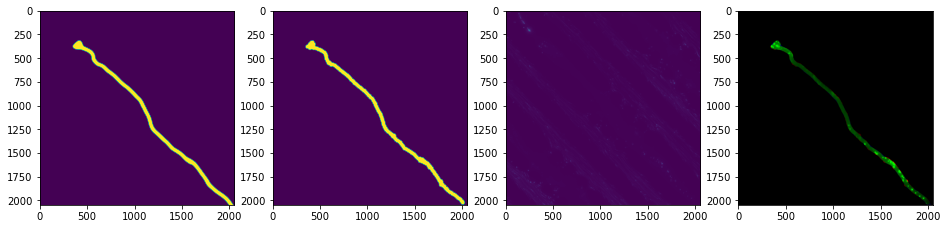

In [17]:
i = 5

tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
mx = np.percentile(green_stack_bs[i],95)
mn = np.percentile(green_stack_bs[i],5)
rgb = (np.dstack((fn_green,tp_green,fp_green))-mn)/(mx-mn)

plt.figure(figsize = [16,4])
plt.subplot(141)
plt.imshow(predictions_CB[i])
plt.subplot(142)
plt.imshow(gutmask_stack[i])
plt.subplot(143)
plt.imshow((green_stack_bs[i]-mn)/(mx-mn))
plt.subplot(144)
plt.imshow(rgb)